In [1]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns

### Compare the Grid of CHIRPS & SMAP Data & Find the Sparser Grid

In [2]:
CHIRPS_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/CHIRPS/FactorA_Processed_Precip_Year_2018.csv')
SMAP_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2018.csv')


In [3]:
CHIRPS_test = CHIRPS_2017[CHIRPS_2017['time'] == '2018-01-01']
CHIRPS_test = CHIRPS_test.rename(columns={'latitude': 'lat', 'longitude': 'lon'})
SMAP_test = SMAP_2017[(SMAP_2017['year'] == 2018) & (SMAP_2017['month'] == 1) & (SMAP_2017['day'] == 1)]

def get_grid_resolution(df, lat_col='lat', lon_col='lon'):
    # Calculate differences in latitudes and longitudes
    lat_diff = np.diff(sorted(df[lat_col].unique()))
    lon_diff = np.diff(sorted(df[lon_col].unique()))

    # Average resolution
    lat_res = np.mean(lat_diff)
    lon_res = np.mean(lon_diff)

    return lat_res, lon_res

# Get grid resolutions for CHIRPS_2017 and SMAP_2017
chirps_res = get_grid_resolution(CHIRPS_test)
smap_res = get_grid_resolution(SMAP_test)

print("CHIRPS Resolution:", chirps_res)
print("SMAP Resolution:", smap_res)

# Determine which dataset has the larger grid
if chirps_res > smap_res:
    target_grid = 'CHIRPS'
    finer_grid_df = SMAP_2017
else:
    target_grid = 'SMAP'
    finer_grid_df = CHIRPS_2017

print("Dataset with larger grid:", target_grid)

# Proceed with regridding finer_grid_df to match the larger grid resolution
# ...


CHIRPS Resolution: (0.05000000716375073, 0.050000009852325465)
SMAP Resolution: (0.08829211718930399, 0.09479072886258136)
Dataset with larger grid: SMAP


### EXMAPLE - Re-Grid/ Interpolate CHIRPS to Match the larger grid of SMAP

In [4]:
# Step 1: Determine the SMAP Grid Points

lat_points = SMAP_test['lat'].unique()
lon_points = SMAP_test['lon'].unique()

# Create a mesh grid for the target (SMAP) resolution
grid_x, grid_y = np.meshgrid(lon_points, lat_points)

In [5]:
# Step 2: Perform the Interpolation

from scipy.interpolate import griddata

# Remove rows with NaN values in the precipitation column
CHIRPS_clean = CHIRPS_test.dropna(subset=['precipitation'])

# Prepare CHIRPS data for interpolation
points = CHIRPS_clean[['lat', 'lon']].values
values = CHIRPS_clean['precipitation'].values

# Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
interpolated_precip = griddata(points, values, (grid_y, grid_x), method='nearest')

# Check the output after interpolation
if not np.any(interpolated_precip > 0):
    print("Warning: Interpolation resulted in zeros only.")

# Convert the interpolated data back to a DataFrame
interpolated_df = pd.DataFrame({
    'lat': grid_y.ravel(),
    'lon': grid_x.ravel(),
    'interpolated_precip': interpolated_precip.ravel()
})


In [6]:
# Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
interpolated_precip = griddata(points, values, (grid_y, grid_x), method='nearest')

before_interpolate = sum(CHIRPS_test[CHIRPS_test['precipitation'] > 0]['precipitation'])
print('total precip before interpolate: ', before_interpolate)
after_interpolate = sum(interpolated_df[interpolated_df['interpolated_precip'] > 0]['interpolated_precip'])
print('total precip after interpolate: ', after_interpolate)

total precip before interpolate:  144425.11763541997
total precip after interpolate:  64918.19705927668


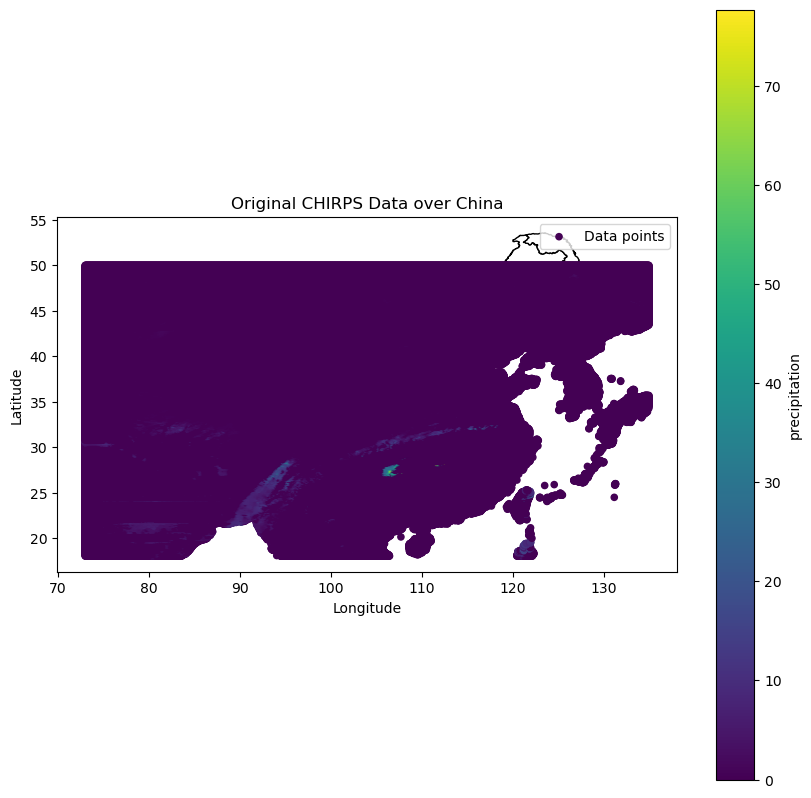

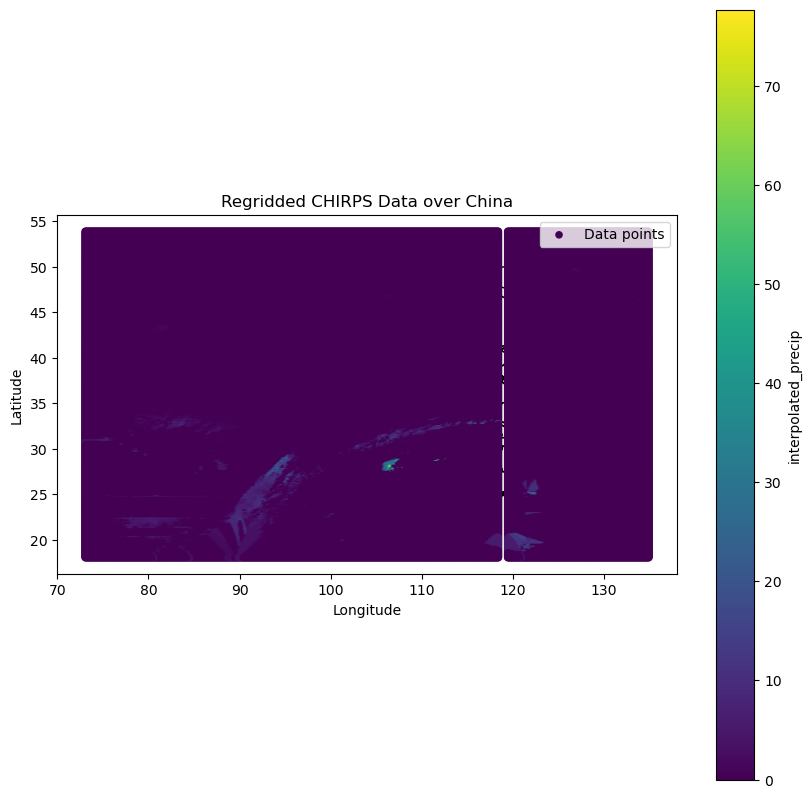

In [7]:
# Validation: Make Sure Re-gridding do not change our data by plotting
import matplotlib.pyplot as plt

def plot_data_with_shapefile(gdf, title, china_map, column):
    fig, ax = plt.subplots(figsize=(10, 10))
    china_map.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, x='lon', y='lat', kind='scatter', c=column, cmap='viridis', label='Data points', colorbar=True)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    
china_shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'  # Update this path
china_map = gpd.read_file(china_shapefile_path)

# Convert CHIRPS_test and interpolated_df to GeoDataFrames
gdf_chirps = gpd.GeoDataFrame(CHIRPS_test, geometry=gpd.points_from_xy(CHIRPS_test.lon, CHIRPS_test.lat))
gdf_interpolated = gpd.GeoDataFrame(interpolated_df, geometry=gpd.points_from_xy(interpolated_df.lon, interpolated_df.lat))

# Plotting
plot_data_with_shapefile(gdf_chirps, 'Original CHIRPS Data over China', china_map, 'precipitation')
plot_data_with_shapefile(gdf_interpolated, 'Regridded CHIRPS Data over China', china_map, 'interpolated_precip')


### Data Preprocess CHIRPS [Re-Grid, Skip No Soil Temp Days, Wet/Dry Status]

In [8]:
def Regrid_CHIRPS_To_SMAP(CHIRPS_df, SMAP_df):
    # Determine the SMAP Grid Points
    lat_points = SMAP_df['lat'].unique()
    lon_points = SMAP_df['lon'].unique()

    # Create a mesh grid for the target (SMAP) resolution
    grid_x, grid_y = np.meshgrid(lon_points, lat_points)
    
    
    # Step 2: Perform the Interpolation
    # Remove rows with NaN values in the precipitation column
    CHIRPS_clean = CHIRPS_test.dropna(subset=['precipitation'])

    # Prepare CHIRPS data for interpolation
    points = CHIRPS_clean[['latitude', 'longitude']].values
    values = CHIRPS_clean['precipitation'].values

    # Interpolate CHIRPS data onto the SMAP grid using 'nearest' method
    interpolated_precip = griddata(points, values, (grid_y, grid_x), method='linear')

    # Check the output after interpolation
    if not np.any(interpolated_precip > 0):
        print("Warning: Interpolation resulted in zeros only.")

    # Convert the interpolated data back to a DataFrame
    interpolated_df = pd.DataFrame({
        'lat': grid_y.ravel(),
        'lon': grid_x.ravel(),
        'interpolated_precip': interpolated_precip.ravel()
    })
    return interpolated_df


In [9]:

CHIRPS_test = CHIRPS_2017[CHIRPS_2017['time'] == '2018-10-12']
SMAP_test = SMAP_2017[(SMAP_2017['year'] == 2018) & (SMAP_2017['month'] == 10) & (SMAP_2017['day'] == 12)]

CHIRPS_regrid_test = Regrid_CHIRPS_To_SMAP(CHIRPS_test, SMAP_test)
before_interpolate = sum(CHIRPS_test[CHIRPS_test['precipitation'] > 0]['precipitation'])
print('total precip before interpolate: ', before_interpolate)
after_interpolate = sum(CHIRPS_regrid_test[CHIRPS_regrid_test['interpolated_precip'] > 0]['interpolated_precip'])
print('total precip after interpolate: ', after_interpolate)

total precip before interpolate:  777615.1700486504
total precip after interpolate:  289849.4835620528


In [10]:
# Fix the datetime values in both df

CHIRPS_2017['time'] = pd.to_datetime(CHIRPS_2017['time'])
CHIRPS_2017 = CHIRPS_2017.sort_values('time')

SMAP_2017['time'] = pd.to_datetime(SMAP_2017[['year', 'month', 'day']])
SMAP_2017 = SMAP_2017.drop(columns=['year', 'month', 'day'])
SMAP_2017 = SMAP_2017.sort_values('time')

In [27]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 12, 31)
current_date = start_date

df = pd.DataFrame()
while current_date <= end_date:
    # Skips the days where is no SMAP Soil Temp Info Available 
    try:
        print(current_date)  
        CHIRPS_test = CHIRPS_2017[CHIRPS_2017['time'] == current_date]
        SMAP_test = SMAP_2017[SMAP_2017['time'] == current_date]
        if SMAP_test.size != 0:

            # regrid the CHIRPS Data
            CHIRPS_regrid_test = Regrid_CHIRPS_To_SMAP(CHIRPS_test, SMAP_test)
            before_interpolate = sum(CHIRPS_test[CHIRPS_test['precipitation'] > 0]['precipitation'])
            after_interpolate = sum(CHIRPS_regrid_test[CHIRPS_regrid_test['interpolated_precip'] > 0]['interpolated_precip'])
            print('total precip: ',  before_interpolate, after_interpolate)

            # Merge the regrid CHIRPS data with the SMAP data
            combined_df = pd.merge(CHIRPS_regrid_test, SMAP_test, on=['lat', 'lon'], how='inner')
            df = pd.concat([df, combined_df])

            
        else:
            print(current_date, ' is not avaiable in SMAP')
    except:
        print(' there is something wrong', current_date)
    
    current_date += timedelta(days=1)


2018-01-01 00:00:00
total precip:  144425.1176354216 59254.45356612406
2018-01-02 00:00:00
total precip:  266206.94255530735 28986.04091447764
2018-01-03 00:00:00
total precip:  1175103.7664805714 410255.1826006318
2018-01-04 00:00:00
total precip:  227958.9703823982 174099.1024781269
2018-01-05 00:00:00
total precip:  206875.17057550128 150288.0642900335
2018-01-06 00:00:00
total precip:  1097777.8423286579 544466.3933267541
2018-01-07 00:00:00
total precip:  653292.5321452785 643161.9400032852
2018-01-08 00:00:00
total precip:  758537.3687418906 749308.5623992764
2018-01-09 00:00:00
total precip:  41019.88108255989 35233.807291429126
2018-01-10 00:00:00
total precip:  68770.27505195231 39652.773327054005
2018-01-11 00:00:00
total precip:  293673.69378788205 157133.68565033263
2018-01-12 00:00:00
total precip:  222638.9571993564 141394.12467829935
2018-01-13 00:00:00
total precip:  594523.3121856058 335187.21933758765
2018-01-14 00:00:00
total precip:  152672.00154949076 98404.4691101

total precip:  775657.0720998035 398742.7638656122
2018-04-26 00:00:00
total precip:  219891.38559838044 87210.10394684729
2018-04-27 00:00:00
total precip:  238071.1466440505 98007.95061679826
2018-04-28 00:00:00
total precip:  467116.528019097 180874.526879433
2018-04-29 00:00:00
total precip:  889271.5153813339 326461.5277869496
2018-04-30 00:00:00
total precip:  1824943.3358713181 772969.9982068975
2018-05-01 00:00:00
total precip:  1985213.177955439 925072.297037241
2018-05-02 00:00:00
total precip:  2309755.748953043 660906.2550522803
2018-05-03 00:00:00
total precip:  1136936.1112495526 422849.8202890536
2018-05-04 00:00:00
total precip:  1362110.3518806538 438998.8290690991
2018-05-05 00:00:00
total precip:  1992788.4776891894 637925.4131432449
2018-05-06 00:00:00
total precip:  2137412.754014093 967854.4032257566
2018-05-07 00:00:00
total precip:  2453670.7181148864 1124019.4670677865
2018-05-08 00:00:00
total precip:  1516538.9037375932 847791.2856282766
2018-05-09 00:00:00
t

2018-08-18 00:00:00
total precip:  3181263.566443068 1347385.0639452494
2018-08-19 00:00:00
total precip:  3533747.4945462737 1575122.009989157
2018-08-20 00:00:00
total precip:  5036602.127624103 1834273.567268035
2018-08-21 00:00:00
total precip:  3088757.8027321254 1479873.808175404
2018-08-22 00:00:00
total precip:  2768666.4521131553 1110089.3096329975
2018-08-23 00:00:00
total precip:  2868585.5886225053 1645641.064920237
2018-08-24 00:00:00
total precip:  3709115.705286436 1978722.080709179
2018-08-25 00:00:00
total precip:  2026979.5003066615 935636.3794096186
2018-08-26 00:00:00
total precip:  2129645.2215715395 1245534.7769579282
2018-08-27 00:00:00
total precip:  2881936.9029112137 1537806.9966408266
2018-08-28 00:00:00
total precip:  3316373.9704630473 1584540.0532726692
2018-08-29 00:00:00
total precip:  3065025.075606257 1544777.4802628409
2018-08-30 00:00:00
total precip:  3975203.771707516 1297151.9913579365
2018-08-31 00:00:00
total precip:  3810860.0574770644 1608453.

total precip:  170946.22618576698 436466.32590779243
2018-12-11 00:00:00
total precip:  95033.41578116553 85561.94050383246
2018-12-12 00:00:00
total precip:  44492.44695470409 11870.19521881616
2018-12-13 00:00:00
total precip:  12667.852391949633 7584.166603671275
2018-12-14 00:00:00
total precip:  24775.903078382587 7685.488648793883
2018-12-15 00:00:00
total precip:  58138.79522726845 8557.963615822922
2018-12-16 00:00:00
total precip:  184257.54443686374 48695.763507029566
2018-12-17 00:00:00
total precip:  183551.5640621924 62329.7668444475
2018-12-18 00:00:00
total precip:  244222.41216603716 64855.60612053706
2018-12-19 00:00:00
total precip:  169074.35294154994 46109.56102152882
2018-12-20 00:00:00
total precip:  127813.59133570374 45861.15507312926
2018-12-21 00:00:00
total precip:  587237.6962290367 316783.2923731612
2018-12-22 00:00:00
total precip:  245002.4586082657 165222.10819265258
2018-12-23 00:00:00
total precip:  236078.33308876355 241286.78898043215
2018-12-24 00:0

In [28]:
df.to_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2018.csv', header = True, index = False)

In [29]:
df

,lat,lon,interpolated_precip,moisture,temp,time
0,39.266701,90.980293,0.0,-9999.0,265.15510,2018-01-01
1,39.266701,84.258301,0.0,-9999.0,269.95853,2018-01-01
2,39.266701,84.164940,0.0,-9999.0,270.00565,2018-01-01
3,39.266701,84.071579,0.0,-9999.0,270.06018,2018-01-01
4,39.266701,83.978218,0.0,-9999.0,270.12097,2018-01-01
...,...,...,...,...,...,...
87495,32.914265,134.113068,0.0,-9999.0,279.28632,2018-12-31
87496,32.914265,134.019714,0.0,-9999.0,279.28632,2018-12-31
87497,32.914265,133.832993,0.0,-9999.0,279.28632,2018-12-31
87498,32.914265,133.926346,0.0,-9999.0,279.28632,2018-12-31


In [32]:
import xarray as xr
import pandas as pd

def df_to_dataset(df, value_col, lat_col='lat', lon_col='lon', time_col='time'):
    """
    Convert a DataFrame to an xarray DataSet.
    """
    # Convert 'time' to datetime if it's not already
    df[time_col] = pd.to_datetime(df[time_col])

    # Set 'time', 'lat', and 'lon' as index
    df = df.set_index([time_col, lat_col, lon_col])

    # Convert DataFrame to DataSet
    ds = xr.Dataset.from_dataframe(df[[value_col]])
    ds = ds.rename({value_col: 'precip'})

    return ds

def process_precipitation_data(ds_china):
    # Calculate the rolling sum of the previous 14 days
    precip_rolling_sum = ds_china['precip'].rolling(time=14, min_periods=1).sum()

    # Convert to DataFrame for easier manipulation
    df = ds_china['precip'].to_dataframe(name='precipitation')
    df['sum_precip_14_days'] = precip_rolling_sum.to_dataframe(name='sum_precip_14_days')

    # The 'precipitation' column already contains the daily precipitation values

    return df


def process_precipitation_data_df(df, precip_column):
    ds_china = df_to_dataset(df, precip_column)
    # Process using your existing function
    processed_df = process_precipitation_data(ds_china)
    # Re-merge with original DataFrame to retain all columns
    final_df = pd.merge(df, processed_df, on=['time', 'lat', 'lon'], how='left')
    final_df = final_df.drop(columns = ['precipitation'])
    return final_df

# Define the function to determine status
def determine_status(row):
    if row['sum_precip_14_days'] > 10:
        return 'wet'
    else:
        return 'dry'


In [73]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017.csv')
# df_test = df[(df['lat'] == df['lat'][87054]) & (df['lon'] == df['lon'][87057])]
# df_test

processed_df = process_precipitation_data_df(df, 'interpolated_precip')
processed_df
processed_df['status'] = processed_df.apply(determine_status, axis=1)
processed_df.to_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017_With_Status.csv', header = True, index = False)

In [33]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2018.csv')
# df_test = df[(df['lat'] == df['lat'][87054]) & (df['lon'] == df['lon'][87057])]
# df_test

processed_df = process_precipitation_data_df(df, 'interpolated_precip')
processed_df
processed_df['status'] = processed_df.apply(determine_status, axis=1)
processed_df.to_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2018_With_Status.csv', header = True, index = False)

In [75]:
df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2019.csv')
# df_test = df[(df['lat'] == df['lat'][87054]) & (df['lon'] == df['lon'][87057])]
# df_test

processed_df = process_precipitation_data_df(df, 'interpolated_precip')
processed_df
processed_df['status'] = processed_df.apply(determine_status, axis=1)
processed_df.to_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2019_With_Status.csv', header = True, index = False)